In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import os
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager
# import raillabel

In [3]:
def initialize_matrices(intrinsic_matrix, rotation_matrix, translation):
    assert rotation_matrix.shape == (3, 3)
    assert translation.shape == (3, 1)
    extrinsic_matrix = np.hstack((rotation_matrix, -rotation_matrix @ translation))
    projection_matrix = intrinsic_matrix @ extrinsic_matrix
    return projection_matrix

In [4]:
lidar_quat = [0.0, 0.0, 0.0, 1.0]
lidar_rotation_matrix = R.from_quat(
    [lidar_quat[0], lidar_quat[1], lidar_quat[2], lidar_quat[3]]
).as_matrix()
lidar_translation = np.asarray([[0.0], [0.0], [0.0]])
lidar_extrinsic_matrix = np.vstack((np.hstack((lidar_rotation_matrix, lidar_translation)), [0, 0, 0 ,1]))
lidar_extrinsic_matrix_inv = np.vstack((np.hstack((lidar_rotation_matrix, - lidar_rotation_matrix @ lidar_translation)), [0, 0, 0 ,1]))

In [7]:
rgb_center_intrinsic_matrix = np.asarray(
    [
        [4609.471892628096, 0.0, 1257.158605934, 0.0],
        [0.0, 4609.471892628096, 820.0498076210201, 0.0],
        [0.0, 0.0, 1.0, 0.0],
    ],
)
rgb_center_quat = [0.00193374, -0.00293566, 0.00271082, 0.99999]
rgb_center_rot = R.from_quat(
    [rgb_center_quat[0], rgb_center_quat[1], rgb_center_quat[2], rgb_center_quat[3]]
) # * R.from_euler('zyx', [90, 0, 90], degrees=True)
rgb_center_rotation_matrix = rgb_center_rot.as_matrix()
rgb_center_translation = np.asarray([[0.0669458], [-0.000911152], [2.05432]])
rgb_center_projection_matrix = initialize_matrices(
    rgb_center_intrinsic_matrix[:,:-1], rgb_center_rotation_matrix, rgb_center_translation
)

rgb_center_extrinsic_matrix = np.hstack((rgb_center_rotation_matrix, rgb_center_translation))
rgb_center_extrinsic_matrix_inv = np.hstack(
    (rgb_center_rotation_matrix, -rgb_center_rotation_matrix.T @ rgb_center_translation)
)

f_r = R.from_euler('zyx', [90, 0, 90], degrees=True).as_matrix()
f_r = np.hstack((f_r, lidar_translation))
f_r = np.vstack((f_r, [0, 0, 0 ,1]))

rgb_center_intrinsic_matrix[:,:-1] @ rgb_center_extrinsic_matrix @ f_r

array([[ 1.23011244e+03, -4.61671899e+03,  2.02010093e+01,
         2.89119085e+03],
       [ 8.02129308e+02, -2.97616460e+01, -4.61252812e+03,
         1.68044479e+03],
       [ 9.99975285e-01, -5.88174706e-03, -3.85152637e-03,
         2.05432000e+00]])

In [8]:
rgb_left_intrinsic_matrix = np.asarray(
    [
        [4622.041473915607, 0.0, 1233.380196060109, 0.0],
        [0.0, 4622.041473915607, 843.3909933480334, 0.0],
        [0.0, 0.0, 1.0, 0.0],
    ]
)
rgb_left_quat = [0.00228435, -0.0104673, 0.173904, 0.984704]
rgb_left_rot = R.from_quat(
    [rgb_left_quat[0], rgb_left_quat[1], rgb_left_quat[2], rgb_left_quat[3]]
) 
rgb_left_rotation_matrix = rgb_left_rot.as_matrix()
rgb_left_translation = np.asarray([[0.0298925], [0.186612], [2.05637]])
rgb_left_projection_matrix = initialize_matrices(
    rgb_left_intrinsic_matrix[:,:-1], rgb_left_rotation_matrix, rgb_left_translation
)

rgb_left_extrinsic_matrix = np.hstack((rgb_left_rotation_matrix, rgb_left_translation))
rgb_left_extrinsic_matrix_inv = np.hstack(
    (rgb_left_rotation_matrix, -rgb_left_rotation_matrix.T @ rgb_left_translation)
)

f_r = R.from_euler('zyx', [-90, 0, -90], degrees=True).as_matrix()
f_r = np.hstack((f_r, lidar_translation))
f_r = np.vstack((f_r, [0, 0, 0 ,1]))

rgb_left_intrinsic_matrix[:,:-1] @ rgb_left_extrinsic_matrix @ f_r

array([[ 1.14148874e+03,  4.36786869e+03, -1.58215698e+03,
         2.67445041e+03],
       [ 8.05576582e+02,  1.60082949e+03,  4.34315174e+03,
         2.59685234e+03],
       [ 9.99770435e-01,  2.14089134e-02,  8.58207043e-04,
         2.05637000e+00]])

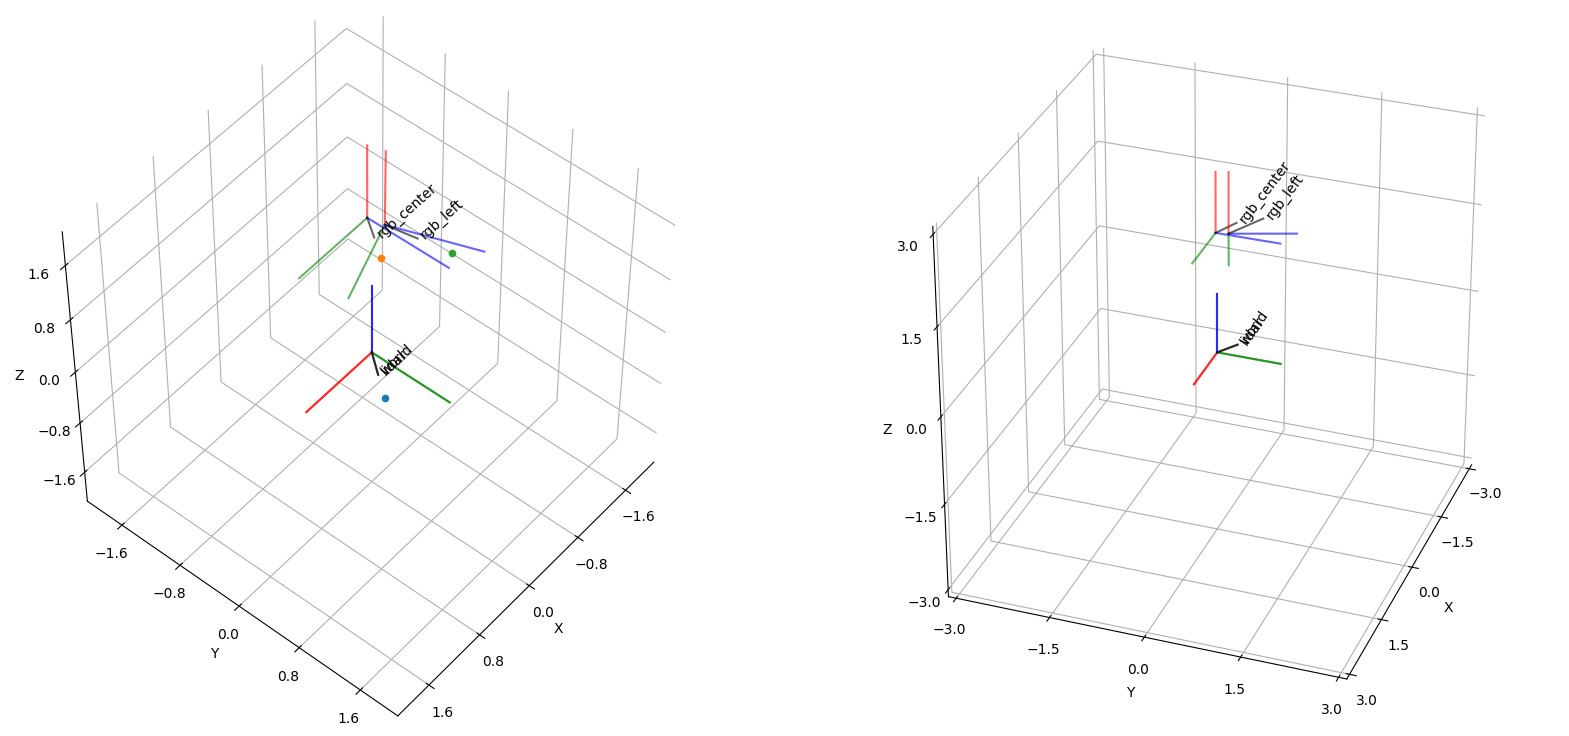

In [13]:
from pytransform3d.transformations import plot_transform
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.transformations import random_transform

lidar2world = np.vstack((np.hstack((lidar_rotation_matrix, lidar_translation)), [0, 0, 0 ,1]))
rgb_center2world = np.vstack((rgb_center_extrinsic_matrix, [0, 0, 0 ,1])) @ f_r
rgb_left2world = np.vstack((rgb_left_extrinsic_matrix, [0, 0, 0 ,1])) @ f_r
# rgb_center2world = np.vstack((np.hstack((rgb_center_rotation_matrix, rgb_center_translation)), [0, 0, 0 ,1]))
# rgb_left2world = np.vstack((np.hstack((rgb_left_rotation_matrix, rgb_left_translation)), [0, 0, 0 ,1]))

tm = TransformManager()
tm.add_transform("lidar", "world", lidar2world)
tm.add_transform("rgb_center", "world", rgb_center2world)
tm.add_transform("rgb_left", "world", rgb_left2world)

p = np.array([1.0, 1.0, 1.0, 1.0])
pt_c =  np.matmul(rgb_center2world, p)
pt_l =  np.matmul(rgb_left2world, p)

plt.figure(figsize=(20, 10))

ax = make_3d_axis(2, 121)
ax = tm.plot_frames_in("world", ax=ax, alpha=0.6)
ax.view_init(50, 40)
ax.scatter(p[0], p[1], p[2])
ax.scatter(pt_c[0], pt_c[1], pt_c[2])
ax.scatter(pt_l[0], pt_l[1], pt_l[2])

ax = make_3d_axis(3, 122)
ax = tm.plot_frames_in("lidar", ax=ax, alpha=0.6)
ax.view_init(30, 20)

plt.show()